<a href="https://colab.research.google.com/github/SeanMuInCa/learn_python/blob/master/groupassignment2025_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Step 1: Import necessary libraries and load datasets
import pandas as pd
import numpy as np

# Load the training and testing datasets
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

# Display basic information
print("Train Data Shape:", df.shape)
print("Test Data Shape:", df_test.shape)

# Check for missing values
print("\nMissing values in train:")
print(df.isnull().sum())

print("\nMissing values in test:")
print(df_test.isnull().sum())

# Show first 5 rows
df.head()


Train Data Shape: (11246, 35)
Test Data Shape: (10784, 36)

Missing values in train:
tappingsteelgrade       0
force_meas              0
speed                   0
entrytemperature        0
entrytemperaturebot     0
entrytemperaturecore    0
entrytemperaturetop     0
entrythickness          0
entrywidth              0
exitthickness           0
zeropoint               0
radius                  0
pctal                   0
pctb                    0
pctc                    0
pctca                   0
pctco                   0
pctcr                   0
pctcu                   0
pcth                    0
pctmg                   0
pctmn                   0
pctmo                   0
pctn                    0
pctnb                   0
pctni                   0
pcto                    0
pctp                    0
pcts                    0
pctsi                   0
pctsn                   0
pctti                   0
pctv                    0
pctzr                   0
fur_line_no             1
dtype

,tappingsteelgrade,force_meas,speed,entrytemperature,entrytemperaturebot,entrytemperaturecore,entrytemperaturetop,entrythickness,entrywidth,exitthickness,...,pctni,pcto,pctp,pcts,pctsi,pctsn,pctti,pctv,pctzr,fur_line_no
0,GL4G71R1,58204143.19,2.634871,1000.661121,939.942163,1034.327117,916.847574,0.080232,3.496171,0.065490,...,0.004,0.0000,0.0153,0.0068,0.135,0.001,0.0097,0.0005,0.000,3.0
1,GL4G71R1,53211949.94,3.947747,1020.846126,991.621746,1044.907925,975.227384,0.039173,3.974567,0.031835,...,0.004,0.0000,0.0119,0.0051,0.128,0.001,0.0090,0.0005,0.000,4.0
2,JV7P1BP6,43513598.87,1.573130,829.078290,786.696648,857.833946,763.533963,0.148507,1.912962,0.136898,...,0.663,0.0025,0.0088,0.0011,0.119,0.001,0.0121,0.0027,0.001,2.0
3,JT5P31P2,33293124.30,2.979649,736.655045,734.483511,738.987016,730.511453,0.014806,2.715973,0.013670,...,0.019,0.0017,0.0150,0.0031,0.283,0.002,0.0128,0.0019,0.001,2.0
4,JT5P32P1,68174217.63,3.401038,893.722030,867.859688,913.164933,850.840106,0.048040,3.654979,0.039451,...,0.010,0.0019,0.0138,0.0040,0.208,0.002,0.0135,0.0011,0.001,3.0


In [4]:
# Step 2: Feature selection and preprocessing

# Split features and target from training data
X = df.drop(columns=["force_meas"])   # Remove target column
y = df["force_meas"].values           # Extract target

# From test set, drop both target and baseline prediction columns
X_test = df_test.drop(columns=["force_meas", "force_pre"])
y_test = df_test["force_meas"].values
baseline_pre = df_test["force_pre"].values

# One-hot encode 'tappingsteelgrad' for all sets
def onehot_encode(df_in):
    return pd.get_dummies(df_in, columns=["tappingsteelgrade"], drop_first=True)

X = onehot_encode(X)
X_test = onehot_encode(X_test)

# Split training data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Align validation and test set columns with training
columns = X_train.columns.tolist()
X_val = X_val.reindex(columns=columns, fill_value=0)
X_test = X_test.reindex(columns=columns, fill_value=0)

# Save the training column structure for future use
import pickle
with open('training_columns.pkl', 'wb') as f:
    pickle.dump(columns, f)

print("Training, validation, and test features are now aligned.")


Training, validation, and test features are now aligned.


In [5]:
# Step 3: Standardize features and apply log transformation to target values

from sklearn.preprocessing import StandardScaler

# Initialize and fit the scaler on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# Save the scaler for later use
with open('scaler_dnn_log.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Log-transform the target variables
y_train_log = np.log(y_train)
y_val_log   = np.log(y_val)

print("Feature scaling and log transformation completed.")


Feature scaling and log transformation completed.


In [6]:
print("Any NaN in X_train_scaled?", np.isnan(X_train_scaled).any())
print("Any Inf in X_train_scaled?", np.isinf(X_train_scaled).any())

print("Max value in X_train_scaled:", np.max(X_train_scaled))
print("Min value in X_train_scaled:", np.min(X_train_scaled))


Any NaN in X_train_scaled? True
Any Inf in X_train_scaled? False
Max value in X_train_scaled: nan
Min value in X_train_scaled: nan


In [7]:
# Replace NaN and Inf with safe default value (e.g., 0.0)
X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0, posinf=0.0, neginf=0.0)
X_val_scaled   = np.nan_to_num(X_val_scaled, nan=0.0, posinf=0.0, neginf=0.0)
X_test_scaled  = np.nan_to_num(X_test_scaled, nan=0.0, posinf=0.0, neginf=0.0)

print("All NaNs and Infs in scaled features replaced.")


All NaNs and Infs in scaled features replaced.


In [8]:
# Step 4: Define and tune a deep neural network using Keras Tuner (with graceful error handling)
!pip install keras-tuner
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import keras_tuner as kt

# Define the tunable DNN model
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=(X_train_scaled.shape[1],)))

    # Add multiple tunable hidden layers
    for i in range(hp.Int('num_layers', 4, 6)):
        units = hp.Int(f'units_{i}', 32, 512, step=32)
        l2_reg = hp.Float(f'l2_{i}', 1e-6, 1e-3, sampling='LOG')
        activation = hp.Choice(f'activation_{i}', ['relu', 'leaky_relu'])
        dropout_rate = hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)
        use_bn = hp.Boolean(f'batchnorm_{i}')

        model.add(layers.Dense(units, kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(layers.LeakyReLU(alpha=0.1) if activation == 'leaky_relu' else layers.Activation('relu'))
        model.add(layers.Dropout(dropout_rate))
        if use_bn:
            model.add(layers.BatchNormalization())

    # Output layer (for regression on log-transformed y)
    model.add(layers.Dense(1))

    # Learning rate
    lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
                  loss='mse',
                  metrics=['mae'])
    return model

# Create the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=30,
    executions_per_trial=1,
    directory='dnn_tuner_dir',
    project_name='rolling_force_dnn'
)

# Define early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_mae', patience=5)

# Start the tuning process with graceful error handling
try:
    tuner.search(
        X_train_scaled, y_train_log,
        validation_data=(X_val_scaled, y_val_log),
        epochs=50,
        callbacks=[early_stop],
        verbose=1
    )
except RuntimeError as e:
    print("⛔ Hyperparameter search ended early due to trial failures.")
    print("✅ Proceeding with the best model found so far.")

# Retrieve the best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters found:")
print(best_hp.values)
print("Now continue")


Trial 30 Complete [00h 01m 28s]
val_mae: 0.13108743727207184

Best val_mae So Far: 0.13108743727207184
Total elapsed time: 00h 43m 39s
Best hyperparameters found:
{'num_layers': 4, 'units_0': 256, 'l2_0': 1.011880135976916e-05, 'activation_0': 'leaky_relu', 'dropout_0': 0.0, 'batchnorm_0': False, 'units_1': 448, 'l2_1': 0.0009034149756449028, 'activation_1': 'leaky_relu', 'dropout_1': 0.1, 'batchnorm_1': False, 'units_2': 224, 'l2_2': 5.6084320584288625e-06, 'activation_2': 'relu', 'dropout_2': 0.0, 'batchnorm_2': False, 'units_3': 448, 'l2_3': 0.00012911437254461346, 'activation_3': 'relu', 'dropout_3': 0.0, 'batchnorm_3': True, 'learning_rate': 0.0007364910610769348, 'units_4': 480, 'l2_4': 0.0007819808585107543, 'activation_4': 'leaky_relu', 'dropout_4': 0.0, 'batchnorm_4': False, 'units_5': 480, 'l2_5': 0.00016849373908993062, 'activation_5': 'relu', 'dropout_5': 0.4, 'batchnorm_5': True}
Now continue


In [9]:
# Step 5: Build and train the final model using the best hyperparameters

# Rebuild the best model from tuner
model = tuner.hypermodel.build(best_hp)

# Define callbacks
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
    )
]

# Train the model
history = model.fit(
    X_train_scaled, y_train_log,
    validation_data=(X_val_scaled, y_val_log),
    epochs=100,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

# Save the trained model
model.save('optimized_dnn_model_advanced_log.h5')
print("Final optimized model has been saved as 'optimized_dnn_model_advanced_log.h5'")


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 94ms/step - loss: 308.0107 - mae: 17.5161 - val_loss: 289.6147 - val_mae: 17.0051 - learning_rate: 7.3649e-04
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 270.3234 - mae: 16.4144 - val_loss: 222.8604 - val_mae: 14.9135 - learning_rate: 7.3649e-04
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 203.4853 - mae: 14.2147 - val_loss: 132.8232 - val_mae: 11.4978 - learning_rate: 7.3649e-04
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 120.0847 - mae: 10.8801 - val_loss: 60.4953 - val_mae: 7.7370 - learning_rate: 7.3649e-04
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 50.0159 - mae: 6.9678 - val_loss: 24.5572 - val_mae: 4.8149 - learning_rate: 7.3649e-04
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 12.9285 - mae: 3.4675 - val_loss: 4.5411 - val_mae: 1.9731 - learning_rate: 7.3649e-04
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 2.0768 - mae: 1.2375 - val_loss: 1.869

Final optimized model has been saved as 'optimized_dnn_model_advanced_log.h5'


In [10]:
# Step 6: Final Evaluation on test.csv

import time
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predict log(force_meas) on the scaled test set
start_time = time.time()
y_pred_log = model.predict(X_test_scaled).flatten()
avg_runtime = (time.time() - start_time) / len(X_test_scaled)

# Reverse log transformation
y_pred = np.exp(y_pred_log)

# True values from test set
y_true = y_test

# Evaluation metrics for our DNN model
mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mse  = mean_squared_error(y_true, y_pred)

print("📊 Final Evaluation on Test Set:")
print(f"✅ DNN MAE : {mae:.4f}")
print(f"✅ DNN RMSE: {rmse:.4f}")
print(f"✅ DNN MSE : {mse:.4f}")
print(f"⚙️  Avg Runtime per sample: {avg_runtime:.6f} seconds")

# Evaluation metrics for baseline force_pre
baseline_mae  = mean_absolute_error(y_true, baseline_pre)
baseline_rmse = np.sqrt(mean_squared_error(y_true, baseline_pre))
baseline_mse  = mean_squared_error(y_true, baseline_pre)

print("\n📉 Baseline Evaluation (force_pre):")
print(f"⚪ Baseline MAE : {baseline_mae:.4f}")
print(f"⚪ Baseline RMSE: {baseline_rmse:.4f}")
print(f"⚪ Baseline MSE : {baseline_mse:.4f}")


337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
📊 Final Evaluation on Test Set:
✅ DNN MAE : 8216453.0887
✅ DNN RMSE: 11080511.5682
✅ DNN MSE : 122777736612110.7656
⚙️  Avg Runtime per sample: 0.000246 seconds

📉 Baseline Evaluation (force_pre):
⚪ Baseline MAE : 2895936.3332
⚪ Baseline RMSE: 3774497.5923
⚪ Baseline MSE : 14246832074143.7891


In [11]:
# Step 9.1: Split train/test data by tappingsteelgrad

# Reload full train/test with original columns
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

# Check unique tappingsteelgrad categories
print("Train categories:", df_train['tappingsteelgrade'].unique())
print("Test categories :", df_test['tappingsteelgrade'].unique())

# Create a mapping to store per-category data
train_groups = dict(tuple(df_train.groupby("tappingsteelgrade")))
test_groups  = dict(tuple(df_test.groupby("tappingsteelgrade")))

# Check sample sizes
for cat in train_groups:
    print(f"✅ Category '{cat}': Train samples = {len(train_groups[cat])}, Test samples = {len(test_groups.get(cat, []))}")


Train categories: ['GL4G71R1' 'JV7P1BP6' 'JT5P31P2' 'JT5P32P1' 'JU5P26P6' 'JL5Q67P1'
 'JT5P31P6' 'GL4G61R1' 'JT5P31P1' 'JT5P32P6' 'IL5R52R1' 'IT4Q33P1'
 'JT5P3AP6' 'JT5Q6JP6' 'JL5Q67P3' 'JT5Q61P6' 'IL6666T1' 'JT5P3AP1'
 'JT5P3AP8' 'JU5F11P6' 'JT5Q6BP1' 'JL4B72P6' 'GL4G62R1' 'JL4B71P6']
Test categories : ['IT4Q33P1' 'JT5P32P6' 'GL4G71R1' 'JU5P26P6' 'JT5P3AP6' 'GL4G61R1'
 'JL4B71P6' 'JT5Q6JP6' 'JT5P32P1' 'JT5P31P6' 'JT5P31P1' 'IL5R52R1'
 'JT5P31P2' 'JL5Q67P1' 'JL5Q67P3' 'IL6666T1' 'JT5Q61P6' 'GL4G62R1'
 'JT5P3AP8' 'JT5P3AP1' 'JT5Q6BP1' 'JL4B72P6' 'JU5F11P6' 'JV7P1BP6']
✅ Category 'GL4G61R1': Train samples = 5042, Test samples = 1273
✅ Category 'GL4G62R1': Train samples = 121, Test samples = 28
✅ Category 'GL4G71R1': Train samples = 5899, Test samples = 1478
✅ Category 'IL5R52R1': Train samples = 5469, Test samples = 1294
✅ Category 'IL6666T1': Train samples = 252, Test samples = 59
✅ Category 'IT4Q33P1': Train samples = 1610, Test samples = 402
✅ Category 'JL4B71P6': Train samples = 115,

In [12]:
# Step 9.2: Select Top 5 categories and train one model per category

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# 获取训练集中按类别的样本数量
category_counts = df_train['tappingsteelgrade'].value_counts()
top_categories = category_counts.head(5).index.tolist()
print("Top 5 Categories:", top_categories)

# 初始化结果列表
results = []

# 为每个类别训练模型并评估
for cat in top_categories:
    print(f"\n🔍 Training model for category: {cat}")

    # 取出当前类别的训练数据
    df_train_cat = df_train[df_train['tappingsteelgrade'] == cat].dropna()
    df_test_cat = df_test[df_test['tappingsteelgrade'] == cat].dropna()

    # 准备特征和目标列
    X_train = df_train_cat.drop(columns=['force_meas'])
    y_train = df_train_cat['force_meas'].values

    X_test = df_test_cat.drop(columns=['force_meas', 'force_pre'])
    y_test = df_test_cat['force_meas'].values
    y_baseline = df_test_cat['force_pre'].values

    # One-hot 编码并对齐列
    X_train = pd.get_dummies(X_train, drop_first=True)
    X_test = pd.get_dummies(X_test, drop_first=True)
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    # 标准化
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 训练模型
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # 评估
    mae_model = mean_absolute_error(y_test, y_pred)
    mae_baseline = mean_absolute_error(y_test, y_baseline)

    print(f"📈 Model MAE     : {mae_model:.2f}")
    print(f"📉 Baseline MAE  : {mae_baseline:.2f}")

    # 存储结果
    results.append({
        'Category': cat,
        'Model_MAE': mae_model,
        'Baseline_MAE': mae_baseline
    })

# 整理为 DataFrame 展示
import pandas as pd
df_results = pd.DataFrame(results)
display(df_results)


Top 5 Categories: ['JU5P26P6', 'JT5P31P1', 'JT5P31P2', 'GL4G71R1', 'JT5P31P6']

🔍 Training model for category: JU5P26P6
📈 Model MAE     : 4219249.69
📉 Baseline MAE  : 3103297.91

🔍 Training model for category: JT5P31P1
📈 Model MAE     : 3663273.65
📉 Baseline MAE  : 3193649.22

🔍 Training model for category: JT5P31P2
📈 Model MAE     : 4225895.05
📉 Baseline MAE  : 3338759.42

🔍 Training model for category: GL4G71R1
📈 Model MAE     : 3922110.47
📉 Baseline MAE  : 2067154.07

🔍 Training model for category: JT5P31P6
📈 Model MAE     : 3795216.39
📉 Baseline MAE  : 2793181.60


,Category,Model_MAE,Baseline_MAE
0,JU5P26P6,4.219250e+06,3.103298e+06
1,JT5P31P1,3.663274e+06,3.193649e+06
2,JT5P31P2,4.225895e+06,3.338759e+06
3,GL4G71R1,3.922110e+06,2.067154e+06
4,JT5P31P6,3.795216e+06,2.793182e+06


In [13]:
# Step 9.3 - Define a simple reusable DNN model for per-category training

def build_simple_dnn(input_shape):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1))  # Output layer
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                  loss='mse',
                  metrics=['mae'])
    return model


In [21]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import numpy as np

results_dnn = []

# 使用刚才的 Top 5 类别
top_categories = ['JU5P26P6', 'JT5P31P1', 'JT5P31P2', 'GL4G71R1', 'JT5P31P6']

for cat in top_categories:
    print(f"\n🚀 Training DNN for category: {cat}")

    # 取出训练/测试子集
    df_train_cat = df_train[df_train['tappingsteelgrade'] == cat].dropna()
    df_test_cat  = df_test[df_test['tappingsteelgrade'] == cat].dropna()

    # 拆分特征和目标
    X_train = df_train_cat.drop(columns=['force_meas'])
    y_train = df_train_cat['force_meas'].values

    X_test = df_test_cat.drop(columns=['force_meas', 'force_pre'])
    y_test = df_test_cat['force_meas'].values
    y_baseline = df_test_cat['force_pre'].values

    # One-hot 编码 + 对齐
    X_train = pd.get_dummies(X_train, drop_first=True)
    X_test = pd.get_dummies(X_test, drop_first=True)
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    # 标准化
    scaler = StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # log 转换目标值
    y_train_log = np.log(y_train + 1e-6)

    # 建立模型
    model = build_simple_dnn(X_train_scaled.shape[1])

    # 回调设置
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

    # 拆分验证集（20%）进行训练
    history = model.fit(
        X_train_scaled, y_train_log,
        validation_split=0.2,
        epochs=100,
        batch_size=64,
        verbose=0,
        callbacks=[early_stop]
    )

    # 预测并反 log
    y_pred_log = model.predict(X_test_scaled).flatten()
    y_pred = np.exp(y_pred_log)

    # 评估结果
    mae_model = mean_absolute_error(y_test, y_pred)
    mae_baseline = mean_absolute_error(y_test, y_baseline)

    print(f"✅ Model MAE    : {mae_model:.2f}")
    print(f"⚪ Baseline MAE : {mae_baseline:.2f}")

    # 存储结果
    results_dnn.append({
        'Category': cat,
        'Model_MAE': mae_model,
        'Baseline_MAE': mae_baseline
    })

# 结果表格展示
df_dnn_results = pd.DataFrame(results_dnn)
display(df_dnn_results)



🚀 Training DNN for category: JU5P26P6
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ Model MAE    : 11254770.23
⚪ Baseline MAE : 3103297.91

🚀 Training DNN for category: JT5P31P1
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ Model MAE    : 7758898.49
⚪ Baseline MAE : 3193649.22

🚀 Training DNN for category: JT5P31P2
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
✅ Model MAE    : 16074941.48
⚪ Baseline MAE : 3338759.42

🚀 Training DNN for category: GL4G71R1
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
✅ Model MAE    : 11602360.21
⚪ Baseline MAE : 2067154.07

🚀 Training DNN for category: JT5P31P6
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
✅ Model MAE    : 11568438.87
⚪ Baseline MAE : 2793181.60


,Category,Model_MAE,Baseline_MAE
0,JU5P26P6,1.125477e+07,3.103298e+06
1,JT5P31P1,7.758898e+06,3.193649e+06
2,JT5P31P2,1.607494e+07,3.338759e+06
3,GL4G71R1,1.160236e+07,2.067154e+06
4,JT5P31P6,1.156844e+07,2.793182e+06


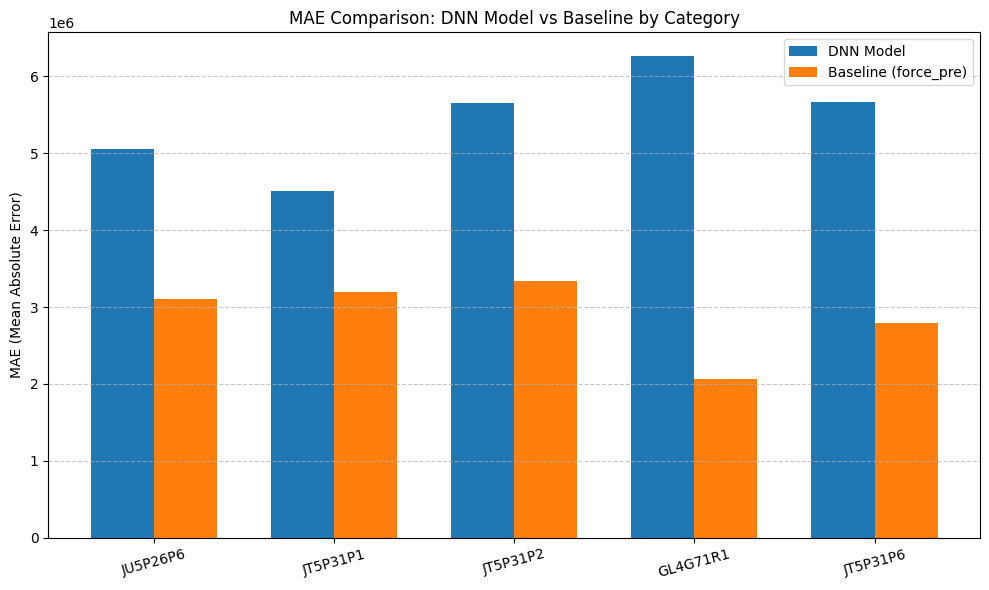